# Train Local

In [1]:
import azureml.core

print(f'SDK Version: {azureml.core.VERSION}')

SDK Version: 1.8.0


In [2]:
from azureml.core.workspace import Workspace
# lets initialise our workspace

ws = Workspace.get(
    name='timer-amls',
    subscription_id='85b036b3-e3ba-4991-9831-e96a1bdd3119',
    resource_group='timer-rg'
)

print(f'Connected to {ws.name} in {ws.resource_group} resource group.')

WARNING - Warning: Falling back to use azure cli login credentials.
If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.
Connected to timer-amls in timer-rg resource group.


An experiment is a logical container in AML workspace. An experiment contains a series of trials called Runs. A single run has run metrics, logs and other output artifacts associated with the run in the experiment.

In [3]:
from azureml.core import Experiment

experiment_name = 'train-on-local'
exp = Experiment(
    workspace= ws,
    name=experiment_name
)

Now, lets make sure we have created the following two files:
- train.py: training script
- mylib.py: supporting libraries

In [4]:
# lets view the train.py script
print('train.py script:')
with open('./train.py', 'r') as f:
    print(f.read())

train.py script:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from azureml.core.run import Run
from sklearn.externals import joblib
import os
import numpy as np
import numpy as np

os.makedirs('./outputs', exist_ok=True)

X, y = load_diabetes(return_X_y = True)

run = Run.get_context()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=.2, 
    random_state=0
)

data ={
    'train': {
        'X': X_train,
        'y': y_train
    },
    'test': {
        'X': X_test,
        'y': y_test
    }
}

# list of numbers from 0 to 1 with 0.05 intervals
alphas = np.arange(0.0, 1.0, 0.05)

# for each alpha value
for alpha in alphas:
    # instantiate model
    reg = Ridge(alpha=alpha)
    # fit our data
    reg.fit(data['train']['X'], data['train']['y'])
    # create predictions
    predictions = reg.predict(data['test']['X'])
    


We will now run our script in three different ways:
- user-managed environment
- system-managed environment
- docker-based execution


Lets start with a User managed environment.

## User Managed Environment 
this is where you will use your environment on your local machine.

In [13]:
from azureml.core import Environment

# define our run config
user_managed_env = Environment('user-managed-env')
user_managed_env.python.user_managed_dependencies = True 
# You can choose a specific Python environment by pointing to a Python path 
#user_managed_env.python.interpreter_path = '/home/johndoe/miniconda3/envs/myenv/bin/python'

# define our script run config
from azureml.core import ScriptRunConfig
src = ScriptRunConfig(
    source_directory='./',
    script='train.py'
)
# pass our config to our script run config
src.run_config.environment = user_managed_env

# create a run
run = exp.submit(config = src)
# wait for the run to complete
run.wait_for_completion(show_output=True)

RunId: train-on-local_1593078871_45fda375
Web View: https://ml.azure.com/experiments/train-on-local/runs/train-on-local_1593078871_45fda375?wsid=/subscriptions/85b036b3-e3ba-4991-9831-e96a1bdd3119/resourcegroups/timer-rg/workspaces/timer-amls

Streaming azureml-logs/60_control_log.txt

Streaming log file azureml-logs/60_control_log.txt
Running: ['/bin/bash', '/private/var/folders/15/rywl4gy907v5xw94jqxlfxmh0000gn/T/azureml_runs/train-on-local_1593078871_45fda375/azureml-environment-setup/conda_env_checker.sh']
Starting the daemon thread to refresh tokens in background for process with pid = 46431


Running: ['python', 'azureml-setup/run_script.py', 'python', 'azureml-setup/context_manager_injector.py', '-i', 'ProjectPythonPath:context_managers.ProjectPythonPath', '-i', 'RunHistory:context_managers.RunHistory', '-i', 'TrackUserError:context_managers.TrackUserError', 'train.py']
Logging experiment running status in history service.
Streaming log file azureml-logs/70_driver_log.txt

Strea

{'runId': 'train-on-local_1593078871_45fda375',
 'target': 'local',
 'status': 'Completed',
 'startTimeUtc': '2020-06-25T09:54:34.176025Z',
 'endTimeUtc': '2020-06-25T09:55:42.07711Z',
 'properties': {'_azureml.ComputeTargetType': 'local',
  'ContentSnapshotId': 'ae9ed326-6242-4c12-bc61-1202becd27fa'},
 'inputDatasets': [],
 'runDefinition': {'script': 'train.py',
  'useAbsolutePath': False,
  'arguments': [],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'local',
  'dataReferences': {},
  'data': {},
  'outputData': {},
  'jobName': None,
  'maxRunDurationSeconds': None,
  'nodeCount': 1,
  'environment': {'name': 'user-managed-env',
   'version': 'Autosave_2020-06-25T09:41:43Z_34538fc2',
   'python': {'interpreterPath': 'python',
    'userManagedDependencies': True,
    'condaDependencies': {'channels': ['anaconda', 'conda-forge'],
     'dependencies': ['python=3.6.2', {'pip': ['azureml-defaults']}],
     'name': 'project_environme

lets view the results of the run on our local machine

In [14]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
train-on-local,train-on-local_1593078871_45fda375,azureml.scriptrun,Completed,Link to Azure Machine Learning studio,Link to Documentation


## System managed environment

Instead of managing the environment yourself, you can ask the system to create a conda environment for you with everything you need. 

In [15]:
from azureml.core.conda_dependencies import CondaDependencies

system_managed_env = Environment('system-managed-env')
system_managed_env.python.user_managed_dependencies = False

cd = CondaDependencies.create(conda_packages=['scikit-learn'])
system_managed_env.python.conda_dependencies = cd 

# create script run config
src = ScriptRunConfig(
    source_directory='./',
    script='train.py'
)

src.run_config.environment = system_managed_env

# create run
run2 = exp.submit(config=src)
run2.wait_for_completion(show_output=True)

RunId: train-on-local_1593078871_45fda375
Web View: https://ml.azure.com/experiments/train-on-local/runs/train-on-local_1593078871_45fda375?wsid=/subscriptions/85b036b3-e3ba-4991-9831-e96a1bdd3119/resourcegroups/timer-rg/workspaces/timer-amls

Execution Summary
RunId: train-on-local_1593078871_45fda375
Web View: https://ml.azure.com/experiments/train-on-local/runs/train-on-local_1593078871_45fda375?wsid=/subscriptions/85b036b3-e3ba-4991-9831-e96a1bdd3119/resourcegroups/timer-rg/workspaces/timer-amls



{'runId': 'train-on-local_1593078871_45fda375',
 'target': 'local',
 'status': 'Completed',
 'startTimeUtc': '2020-06-25T09:54:34.176025Z',
 'endTimeUtc': '2020-06-25T09:55:42.07711Z',
 'properties': {'_azureml.ComputeTargetType': 'local',
  'ContentSnapshotId': 'ae9ed326-6242-4c12-bc61-1202becd27fa'},
 'inputDatasets': [],
 'runDefinition': {'script': 'train.py',
  'useAbsolutePath': False,
  'arguments': [],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'local',
  'dataReferences': {},
  'data': {},
  'outputData': {},
  'jobName': None,
  'maxRunDurationSeconds': None,
  'nodeCount': 1,
  'environment': {'name': 'user-managed-env',
   'version': 'Autosave_2020-06-25T09:41:43Z_34538fc2',
   'python': {'interpreterPath': 'python',
    'userManagedDependencies': True,
    'condaDependencies': {'channels': ['anaconda', 'conda-forge'],
     'dependencies': ['python=3.6.2', {'pip': ['azureml-defaults']}],
     'name': 'project_environme

In [16]:
run2.wait_for_completion(show_output=True)

RunId: train-on-local_1593080008_f1a51f55
Web View: https://ml.azure.com/experiments/train-on-local/runs/train-on-local_1593080008_f1a51f55?wsid=/subscriptions/85b036b3-e3ba-4991-9831-e96a1bdd3119/resourcegroups/timer-rg/workspaces/timer-amls

Streaming azureml-logs/60_control_log.txt

Streaming log file azureml-logs/60_control_log.txt
Starting the daemon thread to refresh tokens in background for process with pid = 46595
Running: ['/bin/bash', '/private/var/folders/15/rywl4gy907v5xw94jqxlfxmh0000gn/T/azureml_runs/train-on-local_1593080008_f1a51f55/azureml-environment-setup/conda_env_checker.sh']
Materialized conda environment not found on target: /Users/abditimer/.azureml/envs/azureml_051fb857f5bfbc18b6890823efdfafbd


Logging experiment preparation status in history service.
Running: ['/bin/bash', '/private/var/folders/15/rywl4gy907v5xw94jqxlfxmh0000gn/T/azureml_runs/train-on-local_1593080008_f1a51f55/azureml-environment-setup/conda_env_builder.sh']
Running: ['conda', '--version']
co

{'runId': 'train-on-local_1593080008_f1a51f55',
 'target': 'local',
 'status': 'Completed',
 'startTimeUtc': '2020-06-25T10:17:54.223245Z',
 'endTimeUtc': '2020-06-25T10:19:21.028872Z',
 'properties': {'_azureml.ComputeTargetType': 'local',
  'ContentSnapshotId': 'ae9ed326-6242-4c12-bc61-1202becd27fa'},
 'inputDatasets': [],
 'runDefinition': {'script': 'train.py',
  'useAbsolutePath': False,
  'arguments': [],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'local',
  'dataReferences': {},
  'data': {},
  'outputData': {},
  'jobName': None,
  'maxRunDurationSeconds': None,
  'nodeCount': 1,
  'environment': {'name': 'system-managed-env',
   'version': 'Autosave_2020-06-25T10:13:29Z_7e35d9fe',
   'python': {'interpreterPath': 'python',
    'userManagedDependencies': False,
    'condaDependencies': {'channels': ['anaconda', 'conda-forge'],
     'dependencies': ['python=3.6.2',
      {'pip': ['azureml-defaults~=1.8.0']},
      'scikit-l

## Docker

We have seen how you can run your code using your local conda environment, getting aml to create a new one on your compute, and now...you can do it in a docker container. 

## Query Run Metrics

You can extract metrics from your run, by calling the `get_metrics()` method.

In [17]:
metrics = run2.get_metrics()
metrics

{'alpha': [0.0,
  0.05,
  0.1,
  0.15000000000000002,
  0.2,
  0.25,
  0.30000000000000004,
  0.35000000000000003,
  0.4,
  0.45,
  0.5,
  0.55,
  0.6000000000000001,
  0.65,
  0.7000000000000001,
  0.75,
  0.8,
  0.8500000000000001,
  0.9,
  0.9500000000000001],
 'mse': [3424.3166882137334,
  3408.9153122589296,
  3372.6496278100326,
  3345.1496434741885,
  3325.294679467877,
  3311.556250928973,
  3302.6736334017255,
  3297.658733944203,
  3295.741064355809,
  3296.316884705675,
  3298.9096058070622,
  3303.1400555275163,
  3308.7042707723226,
  3315.356839962256,
  3322.8983149039614,
  3331.1656169285875,
  3340.0246620321604,
  3349.3646443486023,
  3359.0935697484424,
  3369.1347399130477]}

In [18]:
# Find the lowest MSE logged
import numpy as np 

best_alpha = metrics['alpha'][np.argmin(metrics['mse'])]

print('When alpha is {1:0.2f}, we have min MSE {0:0.2f}.'.format(
    min(metrics['mse']), 
    best_alpha
))

When alpha is 0.40, we have min MSE 3295.74.


Text(0.5, 0, 'Alpha')

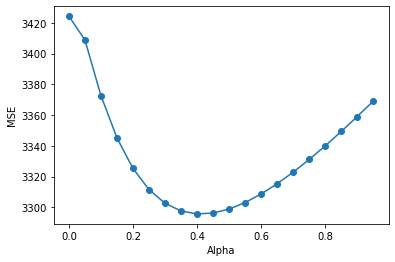

In [19]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.plot(metrics['alpha'], metrics['mse'], marker='o')
plt.ylabel("MSE")
plt.xlabel("Alpha")

we can also see the files that were uploaded

In [20]:
run2.get_file_names()

['azureml-logs/60_control_log.txt',
 'azureml-logs/70_driver_log.txt',
 'logs/azureml/46753_azureml.log',
 'outputs/ridge_0.00.pkl',
 'outputs/ridge_0.05.pkl',
 'outputs/ridge_0.10.pkl',
 'outputs/ridge_0.15.pkl',
 'outputs/ridge_0.20.pkl',
 'outputs/ridge_0.25.pkl',
 'outputs/ridge_0.30.pkl',
 'outputs/ridge_0.35.pkl',
 'outputs/ridge_0.40.pkl',
 'outputs/ridge_0.45.pkl',
 'outputs/ridge_0.50.pkl',
 'outputs/ridge_0.55.pkl',
 'outputs/ridge_0.60.pkl',
 'outputs/ridge_0.65.pkl',
 'outputs/ridge_0.70.pkl',
 'outputs/ridge_0.75.pkl',
 'outputs/ridge_0.80.pkl',
 'outputs/ridge_0.85.pkl',
 'outputs/ridge_0.90.pkl',
 'outputs/ridge_0.95.pkl']

from above, the best metric was when ridge was 0.40.

Lets register this model

In [21]:
model = run.register_model(
    model_name='best_ridge_model',
    model_path='./outputs/ridge_0.40.pkl'
)
print("Registered model:\n --> Name: {}\n --> Version: {}\n --> URL: {}".format(model.name, model.version, model.url))

Registered model:
 --> Name: best_ridge_model
 --> Version: 1
 --> URL: aml://asset/9c01e4d2cc064ea085ddc9a36bae2304
